# CABXD plots on AlaD Replicas with ideal RC
**Zilin Song, 20231228**

## Imports

In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, matplotlib
sns.set_style('ticks')
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 8.

from itertools import combinations

## Loaders: path evolution

In [2]:
evol_wkdir = './0_path_evolution'
evol_phi_indices = [0, 1, 2, 3]
evol_psi_indices = [1, 2, 3, 4]


def get_path_colvar(i_optim: int) -> np.ndarray:
  """Get the CAR constrained path colvar on the i_optim-th run."""
  return np.load(f'{evol_wkdir}/pathopt_{i_optim}/path_colvar.npy')


def get_path_replica_trajectory(i_optim: int, i_replica: int) -> np.ndarray:
  """Return the Replica trajectory at the i_optim-th optimization cycle and the i_replica-th Replica."""
  return np.load(f'{evol_wkdir}/pathopt_{i_optim}/sampler{i_replica}_traj.npz')['replica_coords']


def get_dihedrals(coordinates: np.ndarray, atom_indices: list[int]):
  """Return the dihedrals defined by 4-member atom_indices from coordinates."""

  def compute_dihedral(p0:np.ndarray, p1:np.ndarray, 
                       p2:np.ndarray, p3:np.ndarray):
    """Compute the dihedral between four Cartesian points: p0, p1, p2, p3."""
    B0, B1, B2 = p1 - p0, p2 - p1, p3 - p2
    cos =   np.dot(np.cross(B0, B1), np.cross(B1, B2))                  \
          / np.linalg.norm(np.cross(B0, B1))                            \
          / np.linalg.norm(np.cross(B1, B2))
    sin =   np.dot(np.cross(np.cross(B0, B1), np.cross(B1, B2)), B1)    \
          / np.linalg.norm(np.cross(B0, B1))                            \
          / np.linalg.norm(np.cross(B1, B2))                            \
          / np.linalg.norm(B1)
    return np.arctan2(sin, cos)
  
  dihedrals = []

  for coordinate in range(coordinates.shape[0]):
    cartesian = coordinates[coordinate, :].reshape(-1, 3)
    dihedrals.append(compute_dihedral(cartesian[atom_indices[0], :], cartesian[atom_indices[1], :], 
                                      cartesian[atom_indices[2], :], cartesian[atom_indices[3], :], 
                                      ) / np.pi * 180. )
  
  return np.asarray(dihedrals)

## Path evolution

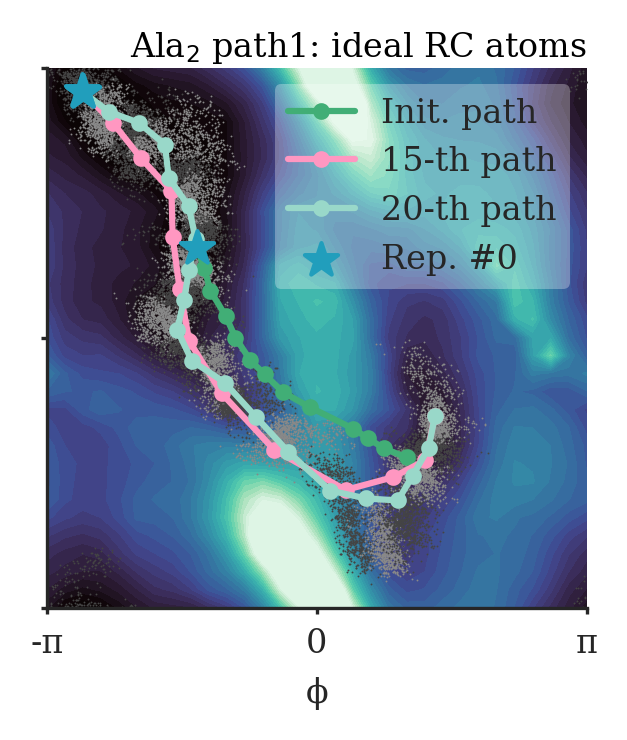

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2., 2.4), dpi=300)

ax.set(xlim=(-180, 180), xticks=(-180, 0, 180), xlabel=r"ϕ", xticklabels=["-π", 0, "π"],
       ylim=(-180, 180), yticks=(-180, 0, 180), ylabel=None, yticklabels=["", "", ""], )

alad_fes = np.load('../../examples/alad_c36m/fes/fes.npz')
ax.contourf(alad_fes['phi_degs'], alad_fes['psi_degs'], alad_fes['energies'], 
            levels=np.linspace(-5, 10, 31), extend='both', cmap=sns.color_palette("mako", as_cmap=True))

for i_replica in range(20):
  traj = get_path_replica_trajectory(i_optim=22, i_replica=i_replica)
  ax.scatter(get_dihedrals(coordinates=traj, atom_indices=evol_phi_indices), 
             get_dihedrals(coordinates=traj, atom_indices=evol_psi_indices), 
             s=.2, linewidths=0., c='#444444' if i_replica % 2 == 0 else '#888888', zorder=1)
  
path_colvar = get_path_colvar(i_optim=0)
ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
        get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
        c='#41ae76', marker='.', label='Init. path')

path_colvar = get_path_colvar(i_optim=15)
ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
        get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
        c="#ff97c1", marker='.', label='15-th path')

path_colvar = get_path_colvar(i_optim=21)
ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
        get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
        c="#99d8c9", marker='.', label='20-th path')

ax.scatter([get_dihedrals(coordinates=get_path_colvar(i_optim=_)[0][np.newaxis, :], atom_indices=evol_phi_indices) for _ in [0, 5, 10, 18]],
           [get_dihedrals(coordinates=get_path_colvar(i_optim=_)[0][np.newaxis, :], atom_indices=evol_psi_indices) for _ in [0, 5, 10, 18]],
           c="#219ebc", marker='*', s=70, zorder=11, label='Rep. #0')
ax.text(x=180, y=205, s=r'Ala$_2$ path1: ideal RC atoms', ha='right', va='top', c='#000000')

ax.set_aspect('equal', adjustable='box')
ax.tick_params(length=1.5)
plt.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1, 1), framealpha=0.3).get_frame().set_linewidth(0.)
sns.despine()
plt.subplots_adjust(left=.1/2., right=1.9/2., top=2.2/2.4, bottom=.4/2.4)
plt.savefig('./figures/alad1_path_evolution.png')

## Path evolution convergence

1 0.000, 0.072, 0.156, 0.210, 0.263, 0.330, 0.425, 0.568, 0.528, 0.452, 0.397, 0.388, 0.306, 0.238, 0.153, 0.148, 0.168, 0.139, 0.061, 0.000 -- 0.250
2 0.000, 0.093, 0.064, 0.055, 0.061, 0.154, 0.230, 0.249, 0.224, 0.195, 0.183, 0.153, 0.223, 0.155, 0.143, 0.201, 0.101, 0.036, 0.015, 0.000 -- 0.127
3 0.000, 0.028, 0.077, 0.037, 0.125, 0.137, 0.146, 0.191, 0.222, 0.224, 0.179, 0.182, 0.181, 0.170, 0.186, 0.166, 0.195, 0.146, 0.065, 0.000 -- 0.133
4 0.000, 0.047, 0.056, 0.076, 0.124, 0.183, 0.203, 0.249, 0.274, 0.273, 0.285, 0.317, 0.325, 0.338, 0.359, 0.364, 0.264, 0.161, 0.067, 0.000 -- 0.198
5 0.000, 0.033, 0.121, 0.119, 0.062, 0.091, 0.104, 0.074, 0.078, 0.046, 0.028, 0.038, 0.061, 0.123, 0.110, 0.116, 0.034, 0.045, 0.007, 0.000 -- 0.065


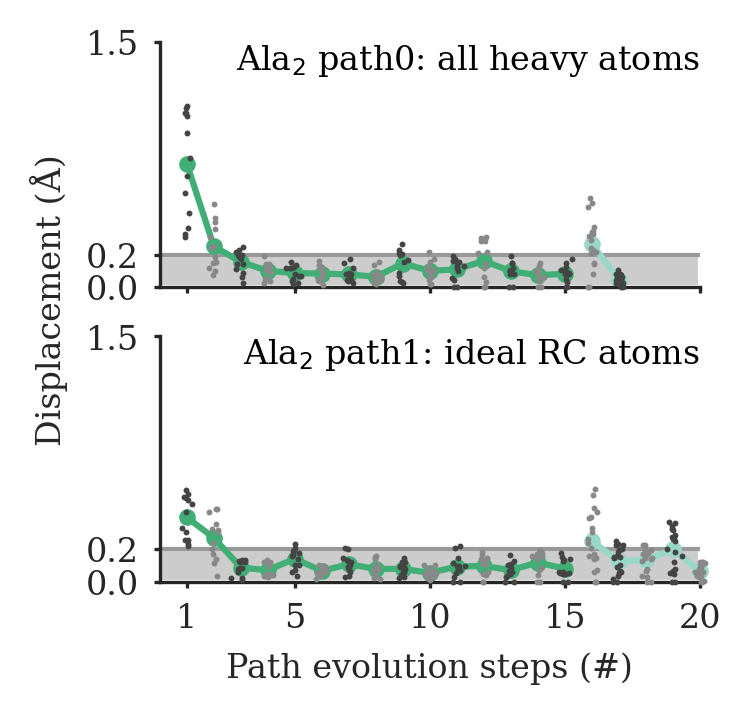

In [4]:
import sys, os
sys.dont_write_bytecode=True
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

from pycospath.utils.geometry import getfn_get_weighted_aligned, getfn_get_rowwise_weighted_rms
get_aligned = getfn_get_weighted_aligned(method_alignment='kabsch', weight_per_dof=np.ones((24, )))
get_row_rms = getfn_get_rowwise_weighted_rms(weight_per_dof=np.ones((24, )), num_dofs_per_atom=3)

# 13-replicas paths.
path13_disp1 = np.zeros((15, 13))
path13_mean1 = np.zeros((15, ))

for i_optim in range(1, 16):
  path_colvar0 = get_path_colvar(i_optim=i_optim-1)
  path_colvar1 = get_path_colvar(i_optim=i_optim  )

  for i_replica in range(13):
    replica_colvar0 = np.copy(path_colvar0[i_replica, :])
    replica_colvar1 = np.copy(path_colvar1[i_replica, :])
    replica_colvar1_aligned = get_aligned(array_to_refer=replica_colvar0, 
                                          array_to_align=replica_colvar1, )
    path13_disp1[i_optim-1, i_replica] = get_row_rms(array0=replica_colvar0        [np.newaxis, :], 
                                                    array1=replica_colvar1_aligned[np.newaxis, :], )[0]
  
  path13_mean1[i_optim-1] = np.mean(path13_disp1[i_optim-1, :])

# 20-replicas paths.
path20_disp1 = np.zeros((5, 20))
path20_mean1 = np.zeros((5, ))

for i_optim in range(17, 22):
  path_colvar0 = get_path_colvar(i_optim=i_optim-1)
  path_colvar1 = get_path_colvar(i_optim=i_optim  )

  for i_replica in range(20):
    replica_colvar0 = np.copy(path_colvar0[i_replica, :])
    replica_colvar1 = np.copy(path_colvar1[i_replica, :])
    replica_colvar1_aligned = get_aligned(array_to_refer=replica_colvar0, 
                                          array_to_align=replica_colvar1, )
    path20_disp1[i_optim-17, i_replica] = get_row_rms(array0=replica_colvar0        [np.newaxis, :], 
                                                     array1=replica_colvar1_aligned[np.newaxis, :], )[0]
  
  path20_mean1[i_optim-17] = np.mean(path20_disp1[i_optim-17, :])
  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(2.4, 2.3), dpi=300,  sharex=True, sharey=True)
ax = axes[0]

from matplotlib.patches import Rectangle
path13_mean0 = np.load('../fig_alad0_path/figures/path13_mean.npy')
path20_mean0 = np.load('../fig_alad0_path/figures/path20_mean.npy')
path13_disp0 = np.load('../fig_alad0_path/figures/path13_disp.npy')
path20_disp0 = np.load('../fig_alad0_path/figures/path20_disp.npy')
ax.add_patch(Rectangle((0, 0), 20, .2, facecolor='#cccccc'))
ax.plot([.0, 20], [.2, .2], '#999999', clip_on=True, lw=1, zorder=1)
ax.plot(np.arange(15)+1, path13_mean0, c="#41ae76", marker='.', clip_on=False)
ax.plot(np.arange(2)+16, path20_mean0, c="#99d8c9", marker='.', clip_on=False)
ax.text(x=20, y=1.5, s=r'Ala$_2$ path0: all heavy atoms', ha='right', va='top', c='#000000')

for i_optim in range(15):
  ax.scatter(np.repeat([i_optim], 13)+np.random.normal(scale=.1, size=13)+1, path13_disp0[i_optim, :], 
             s=2., linewidths=0., c='#444444' if i_optim % 2 == 0 else '#888888', zorder=99, clip_on=False)
  
for i_optim in range(2):
  ax.scatter(np.repeat([i_optim], 20)+np.random.normal(scale=.1, size=20)+16, path20_disp0[i_optim, :], 
             s=2., linewidths=0., c='#888888' if i_optim % 2 == 0 else '#444444', zorder=99, clip_on=False)

ax.tick_params(length=1.5)

ax = axes[1]
ax.set(xlim=( .0 , 20   ), xticks=(1, 5, 10, 15, 20), xlabel=r'Path evolution steps (#)', 
       ylim=(0.  ,  1.25), yticks=(0., .2, 1.5),      ylabel=r'Displacement (Å)', )

from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((0, 0), 20, .2, facecolor='#cccccc'))
ax.plot([.0, 20], [.2, .2], '#999999', clip_on=True, lw=1, zorder=1)
ax.plot(np.arange(15)+1, path13_mean1, c="#41ae76", marker='.', clip_on=False)
ax.plot(np.arange(5)+16, path20_mean1, c="#99d8c9", marker='.', clip_on=False)
ax.text(x=20, y=1.5, s=r'Ala$_2$ path1: ideal RC atoms', ha='right', va='top', c='#000000')

for i_optim in range(15):
  ax.scatter(np.repeat([i_optim], 13)+np.random.normal(scale=.1, size=13)+1, path13_disp1[i_optim, :], 
             s=2., linewidths=0., c='#444444' if i_optim % 2 == 0 else '#888888', zorder=99, clip_on=False)
  
for i_optim in range(5):
  ax.scatter(np.repeat([i_optim], 20)+np.random.normal(scale=.1, size=20)+16, path20_disp1[i_optim, :], 
             s=2., linewidths=0., c='#888888' if i_optim % 2 == 0 else '#444444', zorder=99, clip_on=False)

ax.tick_params(length=1.5)
ax.yaxis.set_label_coords(-.17, 1.15)
sns.despine()
plt.subplots_adjust(left=.5/2.4, right=2.3/2.4, top=2.2/2.3, bottom=.4/2.3)
plt.savefig('./figures/alad1_path_evolution_convergence')


for i in range(path20_disp1.shape[0]): print(i+1, ', '.join([str(f'{r:.3f}') for r in path20_disp1[i]]), '--', f'{path20_mean1[i]:.3f}')

## Loader: CABXD

In [5]:
from openmm.unit import MOLAR_GAS_CONSTANT_R, kelvin, kilocalorie_per_mole

cabxd_wkdir = './1_path_boxedmd/bxd_statistics'

cabxd_kt = (MOLAR_GAS_CONSTANT_R*350.*kelvin).value_in_unit(kilocalorie_per_mole)

def get_cabxd_voronoi_reflection(i_run: int, i_replica:int) -> np.ndarray:
  """CABXD: get the Voronoi penetration statistics."""
  return np.load(f'{cabxd_wkdir}/run{str(i_run)}_sampler{str(i_replica)}_voronoi_reflection.npz')


def compute_cabxd_transition_kernel(i_run:        int, 
                                    num_replicas: int, 
                                    before_steps: int, 
                                    dycorr_steps: int, 
                                    timestepsize: float, 
                                    ) -> np.ndarray:
  """CABXD: compute the transition kernel from the Voronoi penetration statistics."""
  transition_kernel = np.zeros((num_replicas, num_replicas))
  for i_replica in range(num_replicas):
    voronoi_tape = get_cabxd_voronoi_reflection(i_run=i_run, i_replica=i_replica)
    step_index, cell_index = voronoi_tape['step_index'], voronoi_tape['cell_index']
    step_index, cell_index = step_index[step_index<before_steps], cell_index[step_index<before_steps]
    transition_steps = np.copy(step_index[1:  ]-step_index[0:-1])
    transition_cells = np.copy(cell_index[1:  ]                 )
    dycorr_transition_steps = transition_steps[transition_steps>dycorr_steps]
    dycorr_transition_cells = transition_cells[transition_steps>dycorr_steps]

    for j_to_replica in range(num_replicas):
      if np.abs(j_to_replica-i_replica) > 4: # Reflective boundaries to prebent box-to-far-away-box tunneling.
        transition_kernel[i_replica, j_to_replica] = 0
      else:
        i_to_j_hits = dycorr_transition_cells[dycorr_transition_cells == j_to_replica].shape[0]
        transition_kernel[i_replica, j_to_replica] = i_to_j_hits if i_to_j_hits > 0 else 0 # discard the first hit.

    transition_kernel[i_replica, :] = transition_kernel[i_replica, :] / (1_000_000 * float(timestepsize))# (np.sum(dycorr_transition_steps) * float(timestepsize))
  
  return transition_kernel


def compute_cabxd_stationary_distribution(num_replicas: int, transition_kernel: np.ndarray) -> np.ndarray:
  """CABXD: compute the stationary distribution from the MC kernel."""
  P = np.copy(transition_kernel)
  Q = P - np.identity(num_replicas)*np.sum(P, axis=1)

  Q1 = np.concatenate((Q.T, np.ones((num_replicas, ))[np.newaxis, :]), axis=0)
  y1 = np.concatenate((np.zeros((num_replicas, )), [1]))
  
  Q_, R_ = np.linalg.qr(Q1)
  y = Q_.T @ y1

  return np.linalg.solve(R_, y)


def compute_cabxd_mean_first_passage_time(to_replica: int, 
                                          num_replicas:int, 
                                          transition_kernel: np.ndarray, 
                                          ) -> np.ndarray:
  """CABXD: compute the mean first passage time to the to_replica-th replica from the MC kernel."""
  P = np.copy(transition_kernel)
  Q = P - np.identity(num_replicas)*np.sum(P, axis=1)

  # Remove to_replica rows and cols.
  idx = np.arange(num_replicas)
  Qhat = Q[idx!=to_replica, :][:, idx!=to_replica]

  # Solve for MFPTs
  mfpts = np.zeros((num_replicas, ))
  mfpts_to_replica = np.linalg.solve(Qhat, -np.ones((num_replicas-1, )))

  mfpts[idx!=to_replica] = mfpts_to_replica
  
  return mfpts

cabxd_kt

0.695521490524291

## CABXD free energy profile

[-7.53067231e-05  1.92307852e-01  7.28289320e-01  8.38372122e-01
  1.04367980e+00  1.07945074e+00  1.13657989e+00  1.60545720e+00
  1.86415038e+00  1.92322642e+00  3.41879788e+00  4.34774156e+00
  6.35434628e+00  9.63186185e+00  9.79463250e+00  6.06138500e+00
  4.59693293e+00  3.99633856e+00  2.98076723e+00  2.54369971e+00] 

 [0.00440722 0.00343125 0.00241178 0.00596663 0.00700144 0.00911301
 0.0120576  0.01280643 0.01418722 0.01729142 0.01290742 0.01400126
 0.01243061 0.01992565 0.06801354 0.07503101 0.07538712 0.08039923
 0.08056447 0.0867284 ] 




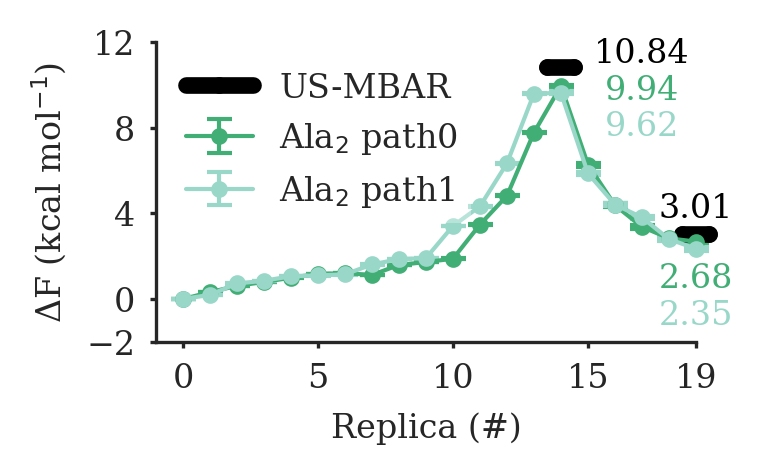

In [6]:
num_runs, num_replicas, before_steps, dycorr_steps, timestepsize = 5, 20, np.inf, 0, .001
batch_idx = np.asarray(list(combinations(range(num_runs), 3)))

bxd_transmats = np.zeros((num_runs, num_replicas, num_replicas))
bxd_fes = np.zeros((batch_idx.shape[0], num_replicas))

for i_run in range(num_runs):
  bxd_transmats[i_run, :, :] = compute_cabxd_transition_kernel(i_run=i_run, 
                                                               num_replicas=num_replicas, 
                                                               before_steps=before_steps, 
                                                               dycorr_steps=dycorr_steps, 
                                                               timestepsize=timestepsize, )
  
for i_trial in range(batch_idx.shape[0]):
  bxd_fes[i_trial, :] = compute_cabxd_stationary_distribution(num_replicas=num_replicas, 
                                                              transition_kernel=np.mean(bxd_transmats[batch_idx[i_trial], :, :], axis=0), )

bxd_fes = -np.log(np.abs(bxd_fes)) * cabxd_kt
bxd_fes -= np.mean(bxd_fes, axis=0)[0]

fe_mean1 = np.mean(bxd_fes, axis=0)
fe_95ci1 = np.std (bxd_fes, axis=0) / np.sqrt(10) * 1.96

fe_mean0 = np.load('../fig_alad0_path/figures/fe_mean.npy')
fe_95ci0 = np.load('../fig_alad0_path/figures/fe_95ci.npy')
print(bxd_fes[num_runs], '\n\n', fe_95ci1, '\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5, 1.5), dpi=300)

ax.errorbar(x=np.arange(20), y=fe_mean0, yerr=fe_95ci0,
            c='#41ae76', marker='.', label=r'Ala$_2$ path0', lw=1., capsize=3., ecolor='#41ae76', clip_on=False)
ax.errorbar(x=np.arange(20), y=fe_mean1, yerr=np.asarray([fe_95ci1]),
            c='#99d8c9', marker='.', label=r'Ala$_2$ path1', lw=1., capsize=3., ecolor='#99d8c9', clip_on=False)
ax.plot([13.5, 14.5], [10.84, 10.84], c="#000000", marker='.', label='US-MBAR', lw=4., clip_on=False)
ax.plot([18.5, 19.5], [ 3.01,  3.01], c="#000000", marker='.',                  lw=4., clip_on=False)

ax.text(x=17, y=10.7, s=f'10.84',                           ha='center', va='bottom', c='#000000')
ax.text(x=17, y= 9. , s=f'{np.round(fe_mean0[14], 2):.2f}', ha='center', va='bottom', c='#41ae76')
ax.text(x=17, y= 7.3, s=f'{np.round(fe_mean1[14], 2):.2f}', ha='center', va='bottom', c='#99d8c9')
ax.text(x=19, y= 3.5, s=f'3.01',                            ha='center', va='bottom', c='#000000')
ax.text(x=19, y=  .2, s=f'{np.round(fe_mean0[-1], 2):.2f}', ha='center', va='bottom', c='#41ae76')
ax.text(x=19, y=-1.5, s=f'{np.round(fe_mean1[-1], 2):.2f}', ha='center', va='bottom', c='#99d8c9')

ax.set(xlim=(-1, 19), xlabel=r'Replica (#)',          xticks=[0, 5, 10, 15, 19],
       ylim=(-2, 12), ylabel=r'ΔF (kcal mol$^{-1}$)', yticks=[-2, 0, 4, 8, 12], )

# ax.legend(frameon=False, fontsize=7.)
ax.tick_params(length=1.5)
sns.despine()
plt.subplots_adjust(left=.5/2.5, right=2.3/2.5, top=1.4/1.5, bottom=.4/1.5)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), framealpha=0.3).get_frame().set_linewidth(0.)
plt.savefig('./figures/alad1_free_energies.png')

## CABXD end-to-end MFPTs

In [8]:
bxd_mfpts = bxd_mfptmat[:, 0, -1] # unit: ps
print(bxd_mfpts.shape)
mean_bxd_mfpts = np.mean(bxd_mfpts, axis=0)

print('\nMFPTs:')
print(f' BXD: {mean_bxd_mfpts:>8.2f} 95ci. {np.std(bxd_mfpts)/np.sqrt(10)*1.96:<8.2f} ps')


(10,)

MFPTs:
 BXD: 2710822.95 95ci. 74380.87 ps
